# Day 8

Following on from Day 7 when I downloaded imagery, I am going to now smooth and try image segmentation.

Rasterio works better with imagery with geospatial referencing for writing in and out so decided to move away from skimage and use rasterio. 

Image Segmentation is essentially the process of partitioning a digital image into multiple segments to simplify and/or change the representation of an image into something that is more meaningful and easier to analyze.

New packages required. 
- Shapely: `conda install -c conda-forge shapely`
- Geopandas: `conda install -c conda-forge geopandas `
- Pycrs: `conda install -c conda-forge pycrs`

Tutorials used: https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html

https://automating-gis-processes.github.io/CSC18/lessons/L6/plotting-raster.html

https://www.earthdatascience.org/courses/earth-analytics-python/multispectral-remote-sensing-in-python/export-numpy-array-to-geotiff-in-python/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import json
import pycrs

In [2]:
datapath = Path('../data/amazon')
datapath18 = datapath.joinpath('20180929T140051').joinpath('amapa20180929T140051.tif');datapath18.exists()
# datapath16 = datapath.joinpath('20160909T140052/amapa20160909T140052.tif')
out_tif = datapath18.parent.joinpath('rasterio_test.tif')

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 4, 'crs': CRS.from_dict(init='epsg:32622'), 'transform': Affine(10.0, 0.0, 300000.0,
       0.0, -10.0, 200040.0)}


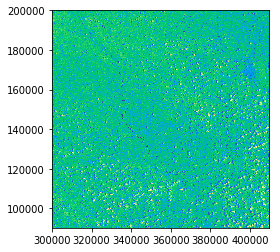

In [3]:
im = rasterio.open(datapath18)
print(im.meta)
show((im, 4), cmap='terrain');

This is a huge image and I want to crop it. I will create a bounding box with Shapely

In [4]:
minx, miny = 340000, 140000
maxx, maxy = 350000, 150000
bbox = box(minx, miny, maxx, maxy)

In [13]:
geo = gpd.GeoDataFrame({'geometry':bbox},
                       index=[0], crs=from_epsg(32622))

In [14]:
geo = geo.to_crs(crs=im.crs.data)

In [15]:
def getFeatures(gdf):
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [16]:
coords = getFeatures(geo); #coords

In [17]:
out_im, out_transform = mask(dataset=im, shapes=coords, crop=True)

In [18]:
out_meta = im.meta.copy()#;out_meta

In [19]:
epsg_code = int(im.crs.data['init'][5:]);epsg_code

32622

In [21]:
out_meta.update({'driver': 'GTiff',
                'height': out_im.shape[1],
                'width': out_im.shape[2],
                'tranform': out_transform,
                'crs': pycrs.parse.from_epsg_code(epsg_code).to_proj4()})
out_meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 1001,
 'height': 1001,
 'count': 4,
 'crs': '+proj=utm +datum=WGS84 +ellps=WGS84 +a=6378137.0 +rf=298.257223563 +pm=0  +units=m +axis=enu +no_defs',
 'transform': Affine(10.0, 0.0, 300000.0,
        0.0, -10.0, 200040.0),
 'tranform': Affine(10.0, 0.0, 340000.0,
        0.0, -10.0, 150000.0)}

In [22]:
with rasterio.open(out_tif, 'w', **out_meta) as dst:
    dst.write(out_im)

In [ ]:
from rasterio.plot import show_hist
show_hist(im, bins=100, lw=0.0, stacked=False, 
          alpha=0.3, histtype='stepfilled')

### Calculate NDVI
NDVI = (NIR - Red) / (NIR + Red)

In [ ]:
image_ndvi = (image_crop[:,:,3] - image_crop[:,:,2]) / (image_crop[:,:,3] + image_crop[:,:,2])

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(image_ndvi, cmap='PiYG')
fig.colorbar(ndvi)
ax.axis('off');